In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [570]:
stages = pd.read_csv('Stage_Info_2023.csv')

In [571]:
results = pd.read_csv('Stage_Results_2023.csv')


/home/woutervdw2/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [572]:
print(results.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239748 entries, 0 to 239747
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   stage_ID      239748 non-null  object 
 1   edition       237320 non-null  float64
 2   year          237320 non-null  float64
 3   stage_number  237320 non-null  float64
 4   rank          235915 non-null  float64
 5   rider         237320 non-null  object 
 6   age           234577 non-null  float64
 7   team          215474 non-null  object 
 8   time_elapsed  235879 non-null  float64
dtypes: float64(6), object(3)
memory usage: 16.5+ MB
None


In [573]:
print("Missing values in stages:")
for column, count in stages.iteritems():
    print(column, count.isnull().sum())


Missing values in stages:
stage_ID 0
year 0
stage_number 0
Distance 0
Origin 0
Destination 0
Type 0


In [574]:
print("Missing values in results:")
for column, count in results.iteritems():
    print(column, count.isnull().sum())

Missing values in results:
stage_ID 0
edition 2428
year 2428
stage_number 2428
rank 3833
rider 2428
age 5171
team 24274
time_elapsed 3869


In [575]:
def fix_str(split):
    for i, w in enumerate(split):
        if len(split) == 9:
            break
        if len(w) == 0:
            continue
        if w[0] == '"':
            start = i
        if w[-1] == '"':
            end = i
            new_str = " ".join([split[start], split[end]])
            split[start] = new_str
            del split[start+1:end+1]
            if len(split) == 9:
                break
    if len(split) != 9:
        print("error:", split)
        print(len(split))
    return split

In [576]:
#Select rows in results where edition, stage and year are missing
missing_rows = results[results['edition'].isnull() & results['stage_number'].isnull() & results['year'].isnull()]

#in these rows split the string in stage_ID and and assign values to the whole row
for index, row in missing_rows.iterrows():
    converted_data = []
    data = fix_str(row['stage_ID'].split(","))
    for item in data:
        if item.isdigit():
            converted_data.append(int(item))
        elif '.' in item and item.replace('.', '').isdigit():
            converted_data.append(float(item))
        elif item.lower() == 'true' or item.lower() == 'false':
            converted_data.append(bool(item))
        else:
            converted_data.append(item)
    #Insert new row in results
    results.loc[index] = converted_data
    

results['year'] = pd.to_datetime(results['year'].astype(int), format='%Y').dt.year

In [577]:
results['rank'] = results['rank'].replace('', np.nan)
results['time_elapsed'] = results["time_elapsed"].replace('', np.nan)

In [578]:
print("Missing values in results:")
for column, count in results.iteritems():
    print(column, count.isnull().sum())

Missing values in results:
stage_ID 0
edition 0
year 0
stage_number 0
rank 1412
rider 0
age 2743
team 21846
time_elapsed 1448


In [579]:
#print rows where team missing
missing_rows = results[results['team'].isnull()]
riders_list = missing_rows['rider'].unique()
print(len(riders_list))
total = 0
for rider in riders_list:
    new_team = None
    rider_rows = results[results['rider'] == rider]
    teams = rider_rows['team'].unique()
    for team in teams:
        if type(team) == str:
            new_team = team
    if new_team is not None:
        results.loc[rider_rows.index, 'team'] = new_team
        print("Found team for rider", rider, ":", new_team)
        total += 1


print("Found teams for", total, "riders")

1286
Found team for rider Henri Paret : France Sud-ouest
Found team for rider Christophe Laurent : Agritubel
Found team for rider Carlo Galetti : Atala
Found team for rider Luigi Ganna : Atala - Dunlop
Found team for rider Eberardo Pavesi : Atala
Found team for rider Jules Masselis : La Sportive
Found team for rider Luigi Chiodi : Atala - Dunlop
Found team for rider Jean Alavoine : Bianchi - Pirelli
Found team for rider Louis Heusghem : La Sportive
Found team for rider Firmin Lambot : La Sportive
Found team for rider Louis Mottiat : La Sportive
Found team for rider Philippe Thys : La Sportive
Found team for rider Henri Pélissier : Bianchi - Pirelli
Found team for rider Joseph Daele Van : La Sportive
Found team for rider Jacques Coomans : La Sportive
Found team for rider Émile Masson : La Sportive
Found team for rider Léon Scieur : La Sportive
Found team for rider Angelo Gremo : Bianchi - Salga
Found team for rider Félix Goethals : La Sportive
Found team for rider Urbain Anseeuw : La Sp

In [580]:
print("Missing values in results:")
for column, count in results.iteritems():
    print(column, count.isnull().sum())

Missing values in results:
stage_ID 0
edition 0
year 0
stage_number 0
rank 1412
rider 0
age 2743
team 18162
time_elapsed 1448


In [607]:
winners = results[results['rank'] == 1]

In [627]:
#Group winners by rider and count how many times they won, select top 10 plot those
grouped_winners = winners.groupby('rider').size().reset_index(name='counts').sort_values(by='counts', ascending=False)


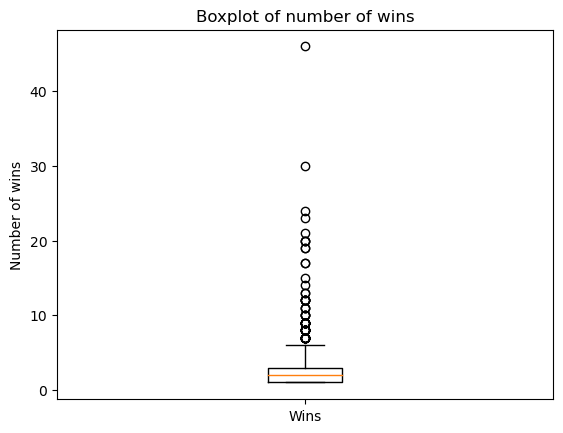

In [621]:
plt.boxplot(grouped_winners['counts'])
plt.title("Boxplot of number of wins")
plt.xticks([1], ['Wins'])
plt.ylabel("Number of wins")
plt.savefig("boxplot_wins.png", bbox_inches='tight')

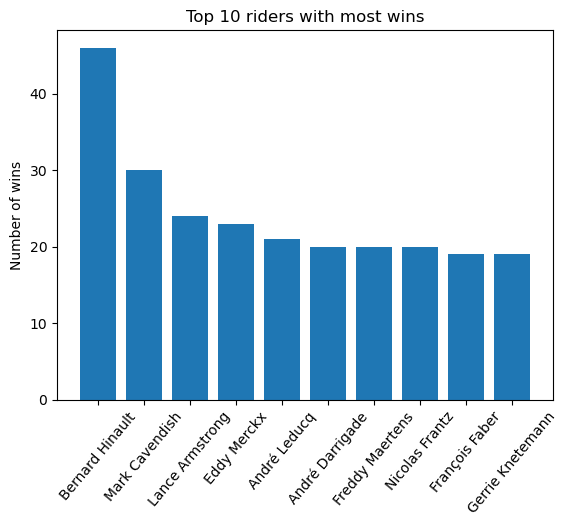

In [622]:
top_10 = grouped_winners.head(10)
plt.bar(top_10['rider'], top_10['counts'])
plt.xticks(rotation=50)
plt.ylabel("Number of wins")
plt.title("Top 10 riders with most wins")
plt.savefig("top_10_wins.png", bbox_inches='tight')

In [633]:
#Group winners by rider and count how many times they won, select top 10 plot those
grouped_winners_year = winners.groupby(['rider', 'year']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [739]:
top_10_year = grouped_winners_year[grouped_winners_year['rider'].isin(list(top_10['rider']))]


<Figure size 1000x1000 with 0 Axes>

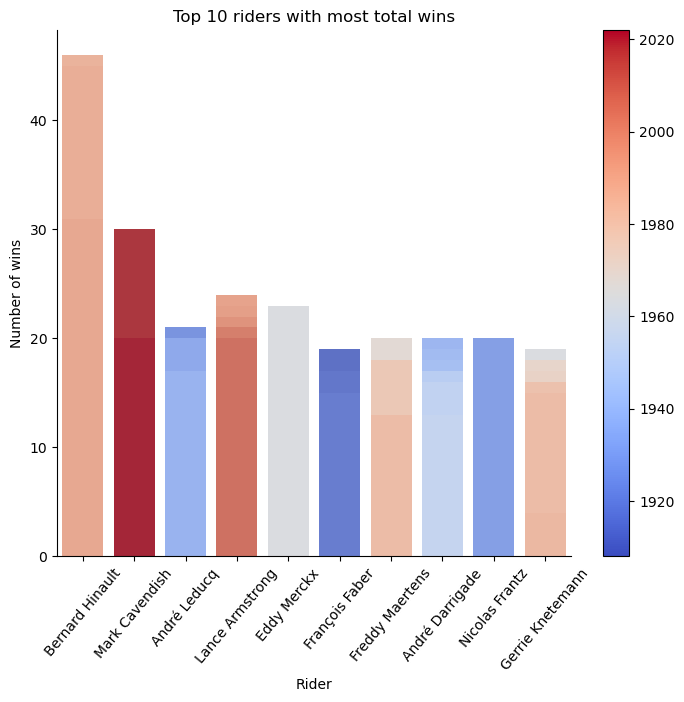

In [820]:
plt.figure(figsize=(10, 10))
norm = plt.Normalize(top_10_year['year'].min(), top_10_year['year'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

ax = sns.catplot(x="rider", y="counts_cumulative", hue="year", data=top_10_year, kind="bar", palette="coolwarm",
                 dodge=False, height=6, aspect=1.2)
ax._legend.remove()
ax.figure.colorbar(sm)
ax.set_xticklabels(rotation=50)
ax.set(xlabel='Rider', ylabel='Number of wins')
ax.set(title='Top 10 riders with most total wins')
plt.savefig("top_10_wins_year.png", bbox_inches='tight')

In [805]:
nr_rides = results['rider'][results['rider'].isin(top_10['rider'])].sort_values()
nr_rides = nr_rides.value_counts(sort=False).sort_index()
print(nr_rides)

André Darrigade     279
André Leducq        181
Bernard Hinault     237
Eddy Merckx         149
François Faber      118
Freddy Maertens     120
Gerrie Knetemann    364
Lance Armstrong     239
Mark Cavendish      169
Nicolas Frantz      131
Name: rider, dtype: int64


In [806]:
#Calculate the proportion of wins for each top 10 rider
top_10.sort_values(by='rider', inplace=True)
top_10['proportion'] = top_10['counts'] / nr_rides.values


/tmp/ipykernel_11452/2271340874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10.sort_values(by='rider', inplace=True)
/tmp/ipykernel_11452/2271340874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['proportion'] = top_10['counts'] / nr_rides.values


/tmp/ipykernel_11452/234744123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10.sort_values(by='proportion', ascending=False, inplace=True)


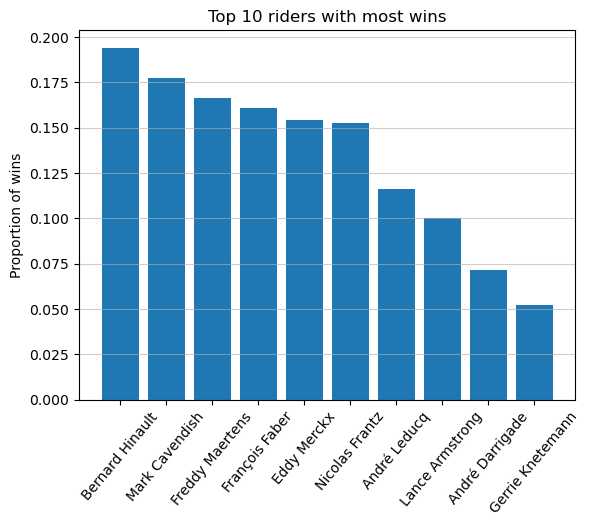

In [821]:
top_10.sort_values(by='proportion', ascending=False, inplace=True)
plt.bar(top_10['rider'], top_10['proportion'])
plt.xticks(rotation=50)
plt.ylabel("Proportion of wins")
plt.title("Top 10 riders with most wins")
plt.grid(axis='y', alpha=0.6)
plt.savefig("top_10_wins_proportion.png", bbox_inches='tight')

In [887]:
age_best_renners = results[(results['rider'].isin(top_10['rider']))&(results['rank']<=3)][['rider', 'age', 'rank']].sort_values(by='rider')
# age_best_renners = age_best_renners.groupby(['age', 'rank']).size().sort_index()
# print(age_best_renners)



In [912]:
age_best_renners = results[results['rank']<=3][['rider', 'age', 'rank']].sort_values(by='rider')
age_best_renners = age_best_renners.groupby(['age', 'rank']).count()
age_best_renners = age_best_renners.unstack(level=1).fillna(0)
age_best_renners.columns = ['1st', '2nd', '3rd']
age_best_renners.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 27 entries, 13.0 to 40.0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1st     27 non-null     float64
 1   2nd     27 non-null     float64
 2   3rd     27 non-null     float64
dtypes: float64(3)
memory usage: 864.0 bytes


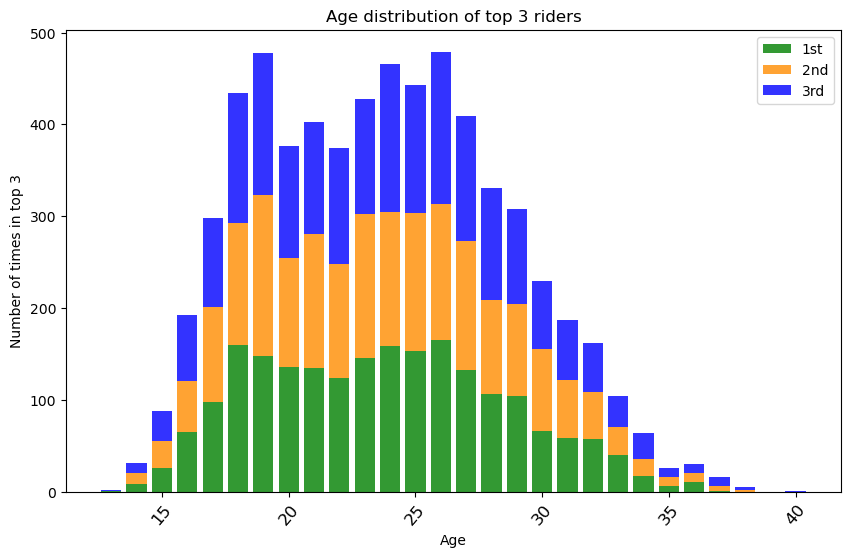

<Figure size 640x480 with 0 Axes>

In [913]:
##lot best teams ranking with stacked bar plot
plt.figure(figsize=(10, 6))
plt.bar(age_best_renners.index, age_best_renners["1st"], label='1st', color='green', alpha=0.8)
plt.bar(age_best_renners.index, age_best_renners["2nd"], bottom=age_best_renners["1st"], label='2nd', color="darkorange", alpha=0.8)
plt.bar(age_best_renners.index, age_best_renners["3rd"], bottom=age_best_renners["1st"]+age_best_renners["2nd"], label='3rd', color="blue", alpha=0.8)
plt.xlabel('Age')
plt.ylabel('Number of times in top 3')
plt.title('Age distribution of top 3 riders')
plt.legend()
plt.xticks(rotation=50, fontsize=12)
plt.show()
plt.savefig('player_ages.png', bbox_inches='tight')

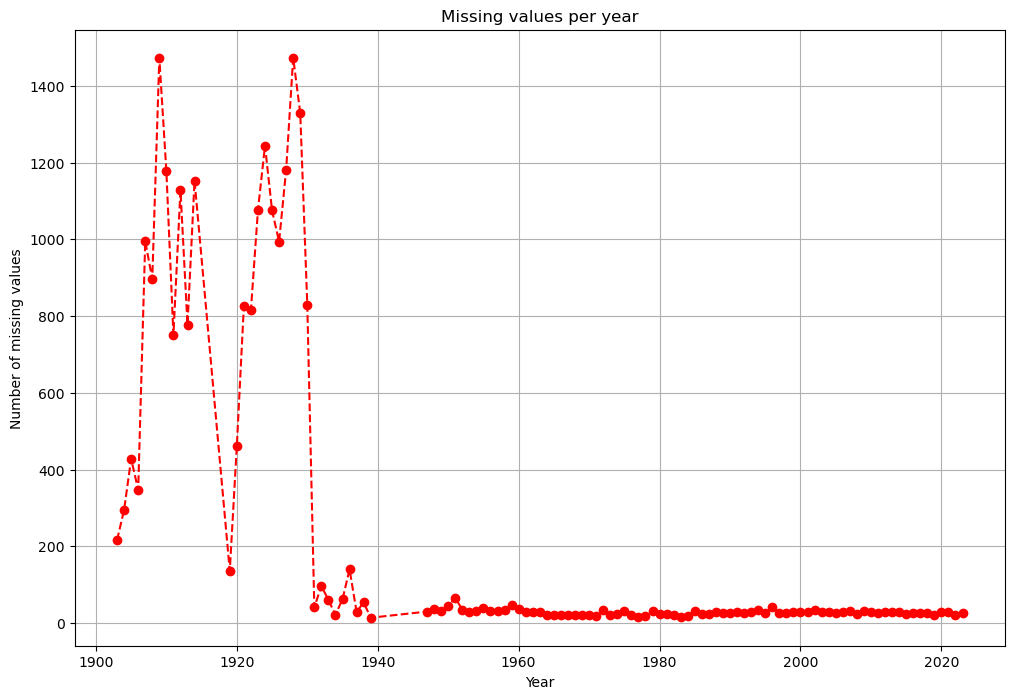

In [911]:
#print number of missing values grouped by year
missing_per_year = results.groupby('year').apply(lambda x: x.isnull().sum()).sum(axis=1)
#Plot number of missing values grouped by year
plt.figure(figsize=(12, 8))
plt.plot(missing_per_year.index, missing_per_year.values, marker='o', linestyle='--', color='r')
plt.title('Missing values per year')
plt.xlabel('Year')
plt.ylabel('Number of missing values')
plt.grid()
plt.savefig('missing_per_year.png')


In [582]:
print("Missing values in stages:")
missing_per_year = results[results['year'] >= 1980].groupby('year').apply(lambda x: x.isnull().sum()).sum(axis=1)
print(len(missing_per_year))

Missing values in stages:
44


In [583]:
#inspect missing values from year 1980
missing_rows = results[(results['year'] >= 1980) & (results.isnull().sum(axis=1) > 0)]
years = {}
for i, row in missing_rows.iterrows():
    if row['year'] not in years:
        years[row['year']] = 0
    edition = row['edition']
    rider = row['rider']
    stage_number = row['stage_number']
    try:
        results[results['edition'] == edition & results['rider'] == rider & results['stage_number'] == stage_number+1]
        print("Found next stage for", edition, rider, stage_number)
    except:
        years[row['year']] += 1
    
print(years)
        

{1980: 14, 1981: 12, 1982: 11, 1983: 8, 1984: 9, 1985: 16, 1986: 14, 1987: 12, 1988: 15, 1989: 13, 1990: 13, 1991: 15, 1992: 13, 1993: 15, 1994: 17, 1995: 14, 1996: 28, 1997: 14, 1998: 13, 1999: 14, 2000: 14, 2001: 15, 2002: 17, 2003: 16, 2004: 14, 2005: 13, 2006: 14, 2007: 16, 2008: 13, 2009: 18, 2010: 14, 2011: 14, 2012: 14, 2013: 14, 2014: 14, 2015: 12, 2016: 13, 2017: 13, 2018: 14, 2019: 11, 2020: 15, 2021: 15, 2022: 11, 2023: 13}


In [584]:
missing_per_year.values - list(years.values())

array([ 9, 12, 10,  8,  9, 16,  9, 12, 15, 13, 13, 15, 13, 14, 16, 12, 14,
       12, 13, 14, 14, 15, 16, 13, 14, 13, 14, 16, 12, 14, 14, 13, 14, 14,
       14, 12, 13, 13, 13, 11, 14, 14, 11, 13])

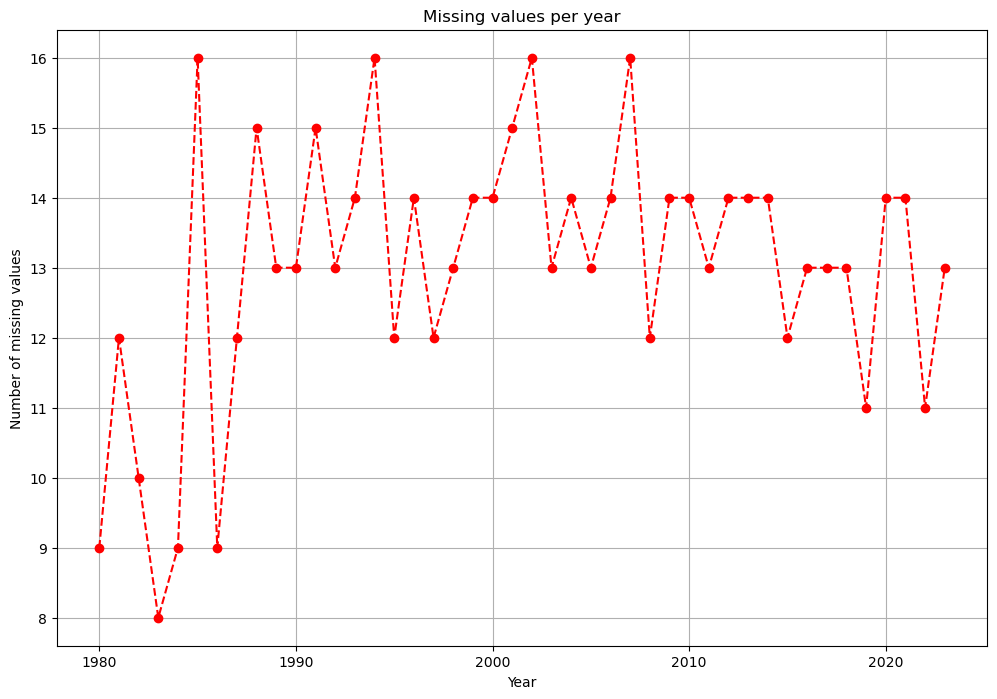

In [585]:
#Plot number of missing values grouped by year from 1980 minus the riders that gave up
plt.figure(figsize=(12, 8))
plt.plot(missing_per_year.index, (missing_per_year.values-list(years.values())), marker='o', linestyle='--', color='r')
plt.title('Missing values per year')
plt.xlabel('Year')
plt.ylabel('Number of missing values')
plt.grid()
plt.savefig('missing_per_year_1980.png')

In [586]:
print("Missing values in results:")
new_results = results[results['year'] >= 1980]
for column, count in new_results.iteritems():
    print(column, count.isnull().sum())

Missing values in results:
stage_ID 0
edition 0
year 0
stage_number 0
rank 595
rider 0
age 13
team 3
time_elapsed 579


In [587]:
#Print rows where age is missing
new_results[new_results['age'].isnull()]

,stage_ID,edition,year,stage_number,rank,rider,age,team,time_elapsed
140865,19961,83.0,1996,1.0,114.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,511.0
141078,19962,83.0,1996,2.0,129.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,12576.0
141221,19964,83.0,1996,4.0,64.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,20922.0
141444,19965,83.0,1996,5.0,89.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,19434.0
141603,19966,83.0,1996,6.0,51.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,28057.0
141885,19967,83.0,1996,7.0,138.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,19444.0
141990,19968,83.0,1996,8.0,51.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,4914.0
142209,19969,83.0,1996,9.0,79.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,16034.0
142389,199610,83.0,1996,10.0,72.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,17204.0
142595,199611,83.0,1996,11.0,93.0,Giancarlo Giupponi,NaN,Carrera Jeans - Vagabond,12878.0


In [588]:
#Print rows where team is missing
new_results[new_results['team'].isnull()]

,stage_ID,edition,year,stage_number,rank,rider,age,team,time_elapsed
144479,19971,84.0,1997,1.0,11.0,Paolo Rosola,34.0,NaN,382.0
144825,19972,84.0,1997,2.0,159.0,Paolo Rosola,34.0,NaN,9038.0
181429,20081,95.0,2008,1.0,176.0,Stefano Casagrande,39.0,NaN,617.0


In [589]:
print([x for x in new_results['rank'] if (type(x) == str)])

[]


In [590]:
#Print rows where rank is missing but time is not
no_rank = new_results[(new_results['rank'].isna() & new_results['time_elapsed'].notnull())]
total = 0
for i, row in no_rank.iterrows():
    stage_nr = row['stage_number']
    edition = row['edition']
    time_elapsed = row['time_elapsed']
    rider = row['rider']
    stage = new_results[(new_results['stage_number']==stage_nr) & (new_results['edition']==edition)].sort_values(by=['time_elapsed']).reset_index(drop=True)
    try:
        new_rank = stage.loc[stage[stage['rider']==rider].index[0] + 1]['rank']-1
        print("Found rank for rider", rider, ":", new_rank)
    except:
        new_rank = stage.loc[stage[stage['rider']==rider].index[0] - 1]['rank']+1
        print("Found rank for rider", rider, ":", new_rank)
    if new_rank == 0:
        print("Error:", rider, edition, stage_nr)
    new_results.loc[i, 'rank'] = np.int(new_rank)
    total += 1
print("Found rank for", total, "riders")
    


Found rank for rider Juan Pujol : 87.0
Found rank for rider Jacques Osmont : 93.0
Found rank for rider Charles Jochums : 61.0
Found rank for rider Erich Jagsch : 87.0
Found rank for rider Bernard Quilfen : 81.0
Found rank for rider Herman Springel Van : 77.0
Found rank for rider Juan Pujol : 87.0
Found rank for rider Jacques Osmont : 93.0
Found rank for rider Charles Jochums : 61.0
Found rank for rider Erich Jagsch : 87.0
Found rank for rider Bernard Quilfen : 81.0
Found rank for rider Gerardo Moncada : 18.0
Found rank for rider Jeff Pierce : 154.0
Found rank for rider Frank Hoste : 157.0
Found rank for rider Roy Knickman : 140.0
Found rank for rider Eric Vanderaerden : 172.0
Found rank for rider Sergio Previtali : 192.0
Found rank for rider Gerard Rue : 91.0
Found rank for rider Alexander Gontchenkov : 92.0
Found rank for rider Benoît Salmon : 11.0
Found rank for rider Joaquín José Rojas : 163.0
Found rank for rider Eduardo Sepúlveda : 173.0
Found rank for 22 riders


/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [591]:
#inspect missing values from year 1980
missing_rows = new_results[(new_results['year'] >= 1980) & (new_results.isnull().sum(axis=1) > 0)]
years = {}
for i, row in missing_rows.iterrows():
    if row['year'] not in years:
        years[row['year']] = 0
    edition = row['edition']
    rider = row['rider']
    stage_number = row['stage_number']
    try:
        results[results['edition'] == edition & results['rider'] == rider & results['stage_number'] == stage_number+1]
        print("Found next stage for", edition, rider, stage_number)
    except:
        years[row['year']] += 1
    
print(years)
        

{1980: 9, 1981: 12, 1982: 10, 1983: 8, 1984: 9, 1985: 16, 1986: 9, 1987: 12, 1988: 15, 1989: 13, 1990: 13, 1991: 15, 1992: 13, 1993: 14, 1994: 16, 1995: 12, 1996: 27, 1997: 14, 1998: 13, 1999: 14, 2000: 14, 2001: 15, 2002: 16, 2003: 13, 2004: 14, 2005: 13, 2006: 14, 2007: 16, 2008: 13, 2009: 18, 2010: 14, 2011: 14, 2012: 14, 2013: 14, 2014: 14, 2015: 12, 2016: 13, 2017: 13, 2018: 14, 2019: 11, 2020: 14, 2021: 14, 2022: 11, 2023: 13}


In [592]:
print("Missing values in stages:")
missing_per_year = new_results[new_results['year'] >= 1980].groupby('year').apply(lambda x: x.isnull().sum()).sum(axis=1)
print(len(missing_per_year))

Missing values in stages:
44


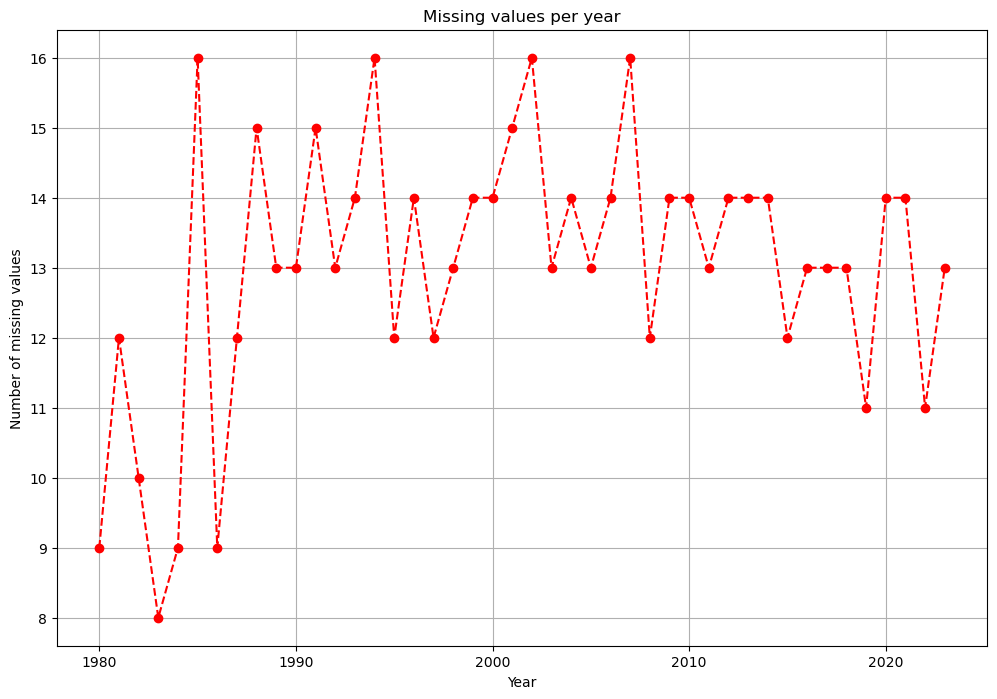

In [593]:

#Plot number of missing values grouped by year from 1980 minus the riders that gave up
plt.figure(figsize=(12, 8))
plt.plot(missing_per_year.index, (missing_per_year.values-list(years.values())), marker='o', linestyle='--', color='r')
plt.title('Missing values per year')
plt.xlabel('Year')
plt.ylabel('Number of missing values')
plt.grid()
plt.savefig('missing_per_year_imputeed_rank.png')

In [594]:
print("Missing values in results:")
for column, count in new_results.iteritems():
    print(column, count.isnull().sum())

Missing values in results:
stage_ID 0
edition 0
year 0
stage_number 0
rank 573
rider 0
age 13
team 3
time_elapsed 579


In [595]:
no_time = new_results[new_results['rank'].notnull() & new_results['time_elapsed'].isnull()]
no_time

,stage_ID,edition,year,stage_number,rank,rider,age,team,time_elapsed
185483,20093,96.0,2009,3.0,1006.0,Levi Leipheimer,29.0,Rabobank ProTeam,NaN
187235,200913,96.0,2009,13.0,104.0,Leonardo Bertagnolli,25.0,Saeco,NaN
187296,200913,96.0,2009,13.0,165.0,Robert Hunter,26.0,Rabobank ProTeam,NaN
187764,200916,96.0,2009,16.0,1005.0,Leonardo Bertagnolli,25.0,Saeco,NaN
193729,20119,98.0,2011,9.0,1005.0,David Zabriskie,26.0,CSC ProTeam,NaN
219128,201812,105.0,2018,12.0,1003.0,Alessandro Petacchi,38.0,Lampre - ISD,NaN


In [596]:
copy = new_results.copy() 
for i, row in no_time.iterrows():
    edition = row['edition']
    rank = row['rank']
    stage_number = row['stage_number']
    new_time = None
    stage_results = copy[(copy['edition']==edition) & (copy['stage_number']==stage_number)].sort_values(by=['rank']).reset_index(drop=True)
    if rank == stage_results['rank'].max():
        new_time = stage_results['time_elapsed'].max()
    elif rank == stage_results['rank'].min():
        new_time = stage_results['time_elapsed'].min()
    else:
        #interpolate
        time_0 = stage_results[stage_results['rank']==rank-1]['time_elapsed'].values[0]
        time_1 = stage_results[stage_results['rank']==rank+1]['time_elapsed'].values[0]
        new_time = (time_0 + time_1)/2
    
    new_results.loc[i, ['time_elapsed']] = np.int64(new_time)
    print("Found time for rider", row['rider'], ":", int(new_time))

Found time for rider Levi Leipheimer : 19112
Found time for rider Leonardo Bertagnolli : 4075
Found time for rider Robert Hunter : 4279
Found time for rider Leonardo Bertagnolli : 18301
Found time for rider David Zabriskie : 16446
Found time for rider Alessandro Petacchi : 19229


/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [597]:
#inspect missing values from year 1980
missing_rows = new_results[(new_results['year'] >= 1980) & (new_results.isnull().sum(axis=1) > 0)]
years = {}
for i, row in missing_rows.iterrows():
    if row['year'] not in years:
        years[row['year']] = 0
    edition = row['edition']
    rider = row['rider']
    stage_number = row['stage_number']
    try:
        results[results['edition'] == edition & results['rider'] == rider & results['stage_number'] == stage_number+1]
        print("Found next stage for", edition, rider, stage_number)
    except:
        years[row['year']] += 1
    
print(years)
        

{1980: 9, 1981: 12, 1982: 10, 1983: 8, 1984: 9, 1985: 16, 1986: 9, 1987: 12, 1988: 15, 1989: 13, 1990: 13, 1991: 15, 1992: 13, 1993: 14, 1994: 16, 1995: 12, 1996: 27, 1997: 14, 1998: 13, 1999: 14, 2000: 14, 2001: 15, 2002: 16, 2003: 13, 2004: 14, 2005: 13, 2006: 14, 2007: 16, 2008: 13, 2009: 14, 2010: 14, 2011: 13, 2012: 14, 2013: 14, 2014: 14, 2015: 12, 2016: 13, 2017: 13, 2018: 13, 2019: 11, 2020: 14, 2021: 14, 2022: 11, 2023: 13}


In [598]:
print("Missing values in stages:")
missing_per_year = new_results[new_results['year'] >= 1980].groupby('year').apply(lambda x: x.isnull().sum()).sum(axis=1)
print(len(missing_per_year))

Missing values in stages:
44


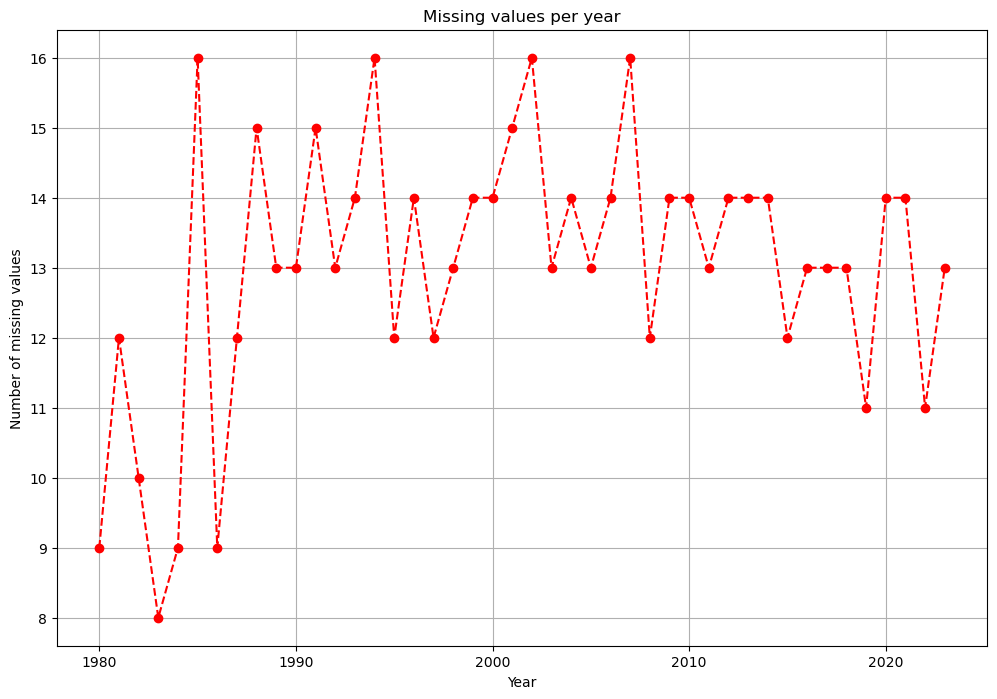

In [599]:
#Plot number of missing values grouped by year from 1980 minus the riders that gave up
plt.figure(figsize=(12, 8))
plt.plot(missing_per_year.index, (missing_per_year.values-list(years.values())), marker='o', linestyle='--', color='r')
plt.title('Missing values per year')
plt.xlabel('Year')
plt.ylabel('Number of missing values')
plt.grid()
plt.savefig('missing_per_year_imputeed_rank_and_time.png')

In [600]:
print("Missing values in results:")
for column, count in new_results.iteritems():
    print(column, count.isnull().sum())

Missing values in results:
stage_ID 0
edition 0
year 0
stage_number 0
rank 573
rider 0
age 13
team 3
time_elapsed 573


In [601]:
#Remove rows with missing values
new_results = new_results.dropna()

In [602]:
print("Missing values in results:")
for column, count in new_results.iteritems():
    print(column, count.isnull().sum())

Missing values in results:
stage_ID 0
edition 0
year 0
stage_number 0
rank 0
rider 0
age 0
team 0
time_elapsed 0


In [603]:
new_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143897 entries, 95262 to 239747
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   stage_ID      143897 non-null  object 
 1   edition       143897 non-null  float64
 2   year          143897 non-null  int64  
 3   stage_number  143897 non-null  float64
 4   rank          143897 non-null  float64
 5   rider         143897 non-null  object 
 6   age           143897 non-null  float64
 7   team          143897 non-null  object 
 8   time_elapsed  143897 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 11.0+ MB


In [604]:
new_results['stage_ID'] = new_results['stage_ID'].astype(int)
new_results['edition'] = new_results['edition'].astype(int)
new_results['stage_number'] = new_results['stage_number'].astype(int)
new_results['rank'] = new_results['rank'].astype(np.float64)

In [605]:
new_results.to_csv("cleaned_data.csv")

In [953]:
team_names = new_results['team'].unique()
print(team_names)

['Renault - Gitane - Campagnolo' 'TI Raleigh - Creda'
 'Ijsboerke - Warncke Eis - Koga Miyata' 'Puch - Sem - Campagnolo'
 'Peugeot - Esso - Michelin' 'La Redoute - Motobecane' 'Teka'
 'Marc - IWC - VRD' 'Daf Trucks - Lejeune - PZ' 'Miko - Mercier - Vivagel'
 'Splendor - Admiral - TV Ekspres' 'RMO - Mavic - Liberia'
 'Boston - IFI - Mavic' 'Lotto - Super Club' 'Kelme' 'Hitachi - VTM'
 'Renault - Elf - Gitane' 'Capri Sonne - Koga Miyata'
 "Boule d'Or - Sunair - Colnago" 'Puch - Wolber - Campagnolo'
 'Vermeer Thijs - Mimo Salons - Gios' 'Sem - France Loire - Campagnolo'
 'Wickes - Splendor - Europ-Decor' "DAF Trucks - Cote d'Or - Gazelle"
 'Boston - Mavic' 'Kelme - Gios' 'Castorama' 'Velda - Flandria'
 'Super-Ser' 'Peugeot - Esso' 'TI-Raleigh' 'Gan - Mercier' 'Brooklyn'
 'Jolly Ceramica' 'Lejeune - BP' 'Kas - Campagnolo' 'Gitane - Campagnolo'
 'Scic - Fiat' 'Miko - Superia' 'Jobo - Wolber - La France' 'Fiat'
 'Frisol - Gazelle - Thirion' 'Miko - Mercier - Hutchinson'
 'Bianchi - Campagnol

In [950]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


# Define a threshold for string similarity
similarity_threshold = 50

# Create a dictionary to store grouped team names
grouped_teams = {}

values = []
# Iterate over each team name
for team_name in team_names:
    # Check if the team name has been grouped already
    if team_name in grouped_teams:
        continue
    
    # Find similar team names based on string similarity
    similar_names = process.extract(team_name, team_names, scorer=fuzz.ratio)
    
    # Group similar team names
    grouped_teams[team_name] = [name for name, score in similar_names if score >= similarity_threshold]
    grouped_teams[team_name].sort()
    if (len(grouped_teams[team_name]) >= 1) and (not grouped_teams[team_name] in values):
        print(grouped_teams[team_name])
        values.append(grouped_teams[team_name])
print(grouped_teams)
print(len(values))

['Gitane - Campagnolo', 'Puch - Eorotex - Campagnolo', 'Puch - Sem - Campagnolo', 'Renault - Gitane', 'Renault - Gitane - Campagnolo']
['TI - Raleigh', 'TI Raleigh - Campagnolo', 'TI Raleigh - Creda', 'TI-Raleigh', 'TI-Raleigh - Campagnolo']
['Capri Sonne - Koga Miyata', 'Ijsboerke - Warncke', 'Ijsboerke - Warncke Eis - Koga Miyata']
['Bianchi - Campagnolo', 'Kas - Campagnolo', 'Puch - Eorotex - Campagnolo', 'Puch - Sem - Campagnolo', 'Puch - Wolber - Campagnolo']
['Alessio - Bianchi', 'Peugeot - Esso', 'Peugeot - Esso - Michelin', 'Peugeot - Shell', 'Peugeot - Shell - Michelin']
['Caja Rural - Orbea', 'La Redoute', 'La Redoute - Motobecane', 'Lampre - Merida', 'Renault - Gitane']
['Ariostea', 'Kas', 'Team CSC', 'Team Katusha', 'Teka']
['HTC - High Road', 'Lampre - ISD', 'Marc - IWC - VRD', 'PDM - Ultima - Concorde']
["DAF Trucks - Cote d'Or - Gazelle", 'DAF Trucks - Tévé Blad - Rossin', 'Daf Trucks', 'Daf Trucks - Lejeune - PZ', 'Lejeune - BP']
['Coop - Mercier - Mavic', 'Miko - Merci

In [954]:
new_teams = [team[0] for team in grouped_teams.values()]
new_teams_df = new_results.copy()
new_teams_df['team'] = new_teams_df['team'].replace(new_teams)
len(new_teams_df['team'].unique())

207

In [952]:
new_teams

['Gitane - Campagnolo',
 'TI - Raleigh',
 'Capri Sonne - Koga Miyata',
 'Bianchi - Campagnolo',
 'Alessio - Bianchi',
 'Caja Rural - Orbea',
 'Ariostea',
 'HTC - High Road',
 "DAF Trucks - Cote d'Or - Gazelle",
 'Coop - Mercier - Mavic',
 'Splendor - Admiral - TV Ekspres',
 'RMO - Liberia - Mavic',
 'Boston - IFI - Mavic',
 'Jobo - Superia',
 'Kelme',
 'Bianchi - Faema',
 'Renault - Elf',
 'Capri Sonne - Campagnolo - Merckx',
 "Boule d'Or - Colnago - Campagnolo",
 'Bianchi - Campagnolo',
 'Vermeer - Thijs - Gios',
 'Bianchi - Campagnolo',
 'Euro Shop - Splendor',
 "DAF Trucks - Cote d'Or - Gazelle",
 'Boston - IFI - Mavic',
 'Kelme',
 'Astana',
 'GAN - Lemond',
 'Liberty Seguros',
 'Peugeot - Esso',
 'Castorama - Raleigh',
 'Coop - Mercier - Mavic',
 'Barloworld',
 'Jolly Ceramica',
 'Daf Trucks - Lejeune - PZ',
 'Bianchi - Campagnolo',
 'Bianchi - Campagnolo',
 'Asics - CGA',
 'Cilo - Aufina',
 'Fiat - La France',
 'FDJ - BigMat',
 'Frisol - Gazelle - Thirion',
 'Coop - Mercier - Mavi